In [1]:
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import sys, tqdm
from scipy.interpolate import interp1d, griddata

import numpy.ma as ma

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline, sinks
from plotting_setup import *

In [2]:
NSIDE = 3
print(
    "Approximate resolution at NSIDE {} is {:.3f} rad".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=False)
    )
)


Approximate resolution at NSIDE 3 is 0.341 rad


### $N_{pix} = 12 \cdot {N_{side}}^2$

In [3]:
NPIX = hp.nside2npix(NSIDE); print(NPIX, NSIDE)

108 3


<Figure size 1200x800 with 0 Axes>

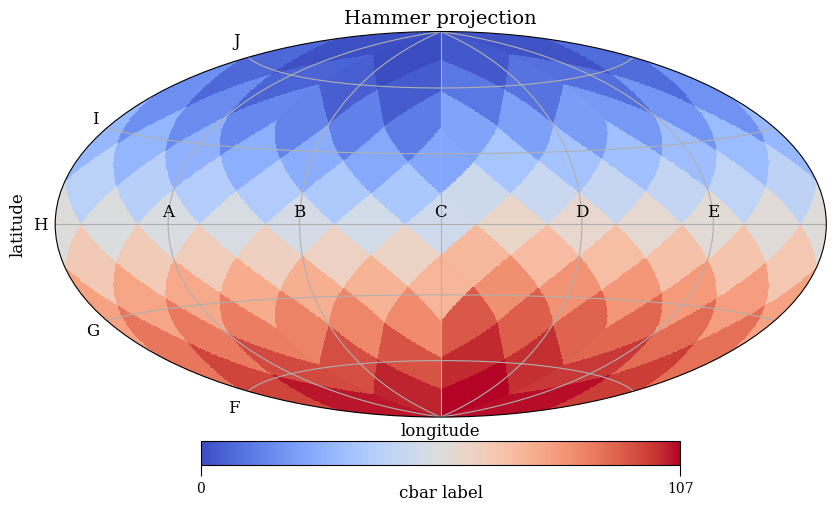

In [4]:
# An example of Hammer projection we are going for with 12 pixels
# Custom labels

m = np.arange(NPIX)

fig = plt.figure(figsize = (12,8)) 
ax = projview(
    m,
    coord=["G"],
    cmap = 'coolwarm',
    graticule=True,
    graticule_labels=True,
    unit=r"cbar label",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    custom_xtick_labels=["A", "B", "C", "D", "E"],
    custom_ytick_labels=["F", "G", "H", "I", "J"],
);

### Vectors can be used to represent coordinates
### $$Latitude:\;\theta\;\in\; \{0, \pi\}$$
### $$Longtitude:\;\phi\;\in\;\{0, 2\pi\}$$

In [5]:
vec = hp.ang2vec(0, np.pi * 3 / 4)
print(vec)

[-0.  0.  1.]


#### We can find the indices of all the pixels within degrees of that point and then change the value of the map at those indices:

<Figure size 1200x800 with 0 Axes>

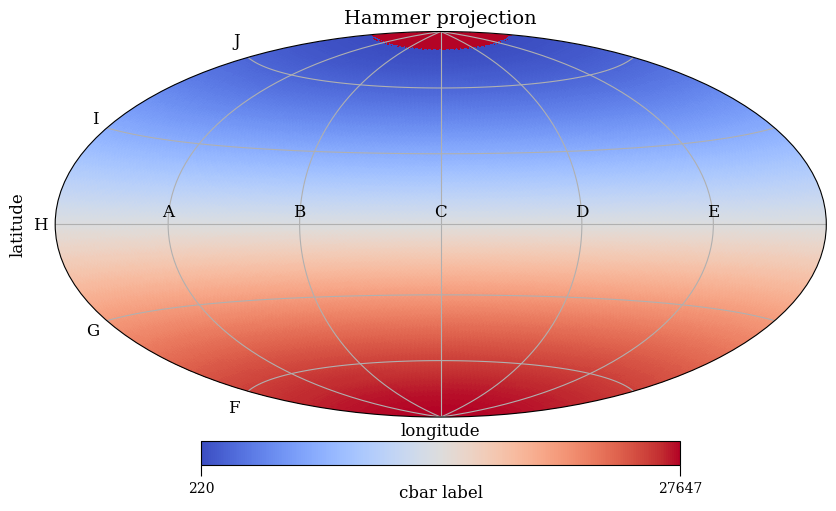

In [6]:
NSIDE = 48
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(10))
NPIX = hp.nside2npix(NSIDE)
m = np.arange(NPIX)
m[ipix_disc] = m.max()
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    m,
    coord=["G"],
    cmap = 'coolwarm',
    graticule=True,
    graticule_labels=True,
    unit=r"cbar label",
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    custom_xtick_labels=["A", "B", "C", "D", "E"],
    custom_ytick_labels=["F", "G", "H", "I", "J"],
);

In [7]:
theta, phi = np.degrees(hp.pix2ang(nside=32, ipix=[0, 1, 2, 3, 4]))
print(theta, phi)

[1.46197116 1.46197116 1.46197116 1.46197116 2.92418036] [ 45.  135.  225.  315.   22.5]


In [8]:
theta, phi = (hp.pix2ang(nside=32, ipix=[0, 1, 2, 3, 4], lonlat = True))
print(theta, phi)

[ 45.  135.  225.  315.   22.5] [88.53802884 88.53802884 88.53802884 88.53802884 87.07581964]


In [9]:
print(np.degrees(hp.nside2resol(32)))

1.8322594196359498


# Map Dispatch data into a healpix map

In [10]:
data = pipeline(snap = 362, run = 'sink13fmr05', sink_id=13)
data.recalc_L(verbose = 1); data.calc_trans_xyz(verbose = 0)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:10<00:00, 401.26it/s]


Converged mean angular momentum vector after 1 iteration(s)


100%|██████████| 4165/4165 [00:01<00:00, 2918.77it/s]


  0%|          | 0/961 [00:00<?, ?it/s]

100%|██████████| 961/961 [00:00<00:00, 1684.03it/s]


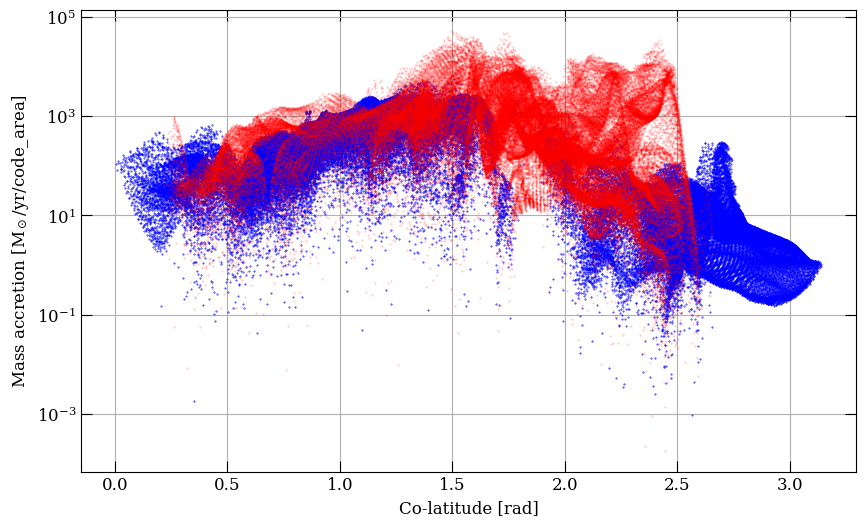

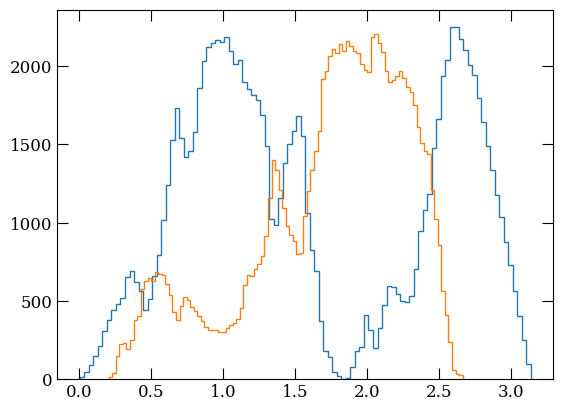

In [11]:
shell_r=50; shell_Δpct=0.05

shell_r /= data.au_length
Δ_r = np.maximum(shell_Δpct * shell_r, 2.5 * 0.5 ** data.lmax) 

colatitude = [] # θ going from 0 to π from north to south
longtitude = [] # φ going from 0 to 2π around the equator 
patch_values = []
patch_mass = []
cell_level = []

pp = [p for p in data.sn.patches if (p.dist_xyz < shell_r * 2).any() and p.level > 5]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

for p in tqdm.tqdm(sorted_patches, disable=(not data.loading_bar)):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position) ** 2).sum() < (p.size ** 2).sum() / 12]
    if len(leafs) == 8: continue
    to_extract = (p.dist_xyz < shell_r + Δ_r) & (p.dist_xyz > shell_r - Δ_r)
    for lp in leafs:
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all(((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None])), axis=0)
        to_extract *= covered_bool

    new_xyz = p.trans_xyz[:, to_extract].T
    new_R = np.linalg.norm(new_xyz, axis=1)
    new_value = (p.var('d') * np.sum((p.trans_vrel *  p.trans_xyz / np.linalg.norm(p.trans_xyz, axis=0)), axis=0))[to_extract].T
    mass = p.m[to_extract].T
    longtitude.extend((np.arctan2(new_xyz[:, 1], new_xyz[:, 0]) + np.pi).tolist())
    colatitude.extend(np.arccos(new_xyz[:, 2] / new_R).tolist()) 

    patch_values.extend(new_value.tolist())
    patch_mass.extend(mass.tolist())
    cell_level.extend(p.level * np.ones(len(mass)))

longtitude = np.asarray(longtitude)
colatitude = np.asarray(colatitude)
patch_values = np.asarray(patch_values)
patch_mass = np.asarray(patch_mass)
cell_level = np.asarray(cell_level)


fig, axs = plt.subplots( figsize = (10,6))

axs.set(ylabel = 'Mass accretion [M$_\odot$/yr/code_area]', xlabel = 'Co-latitude [rad]')
axs.grid()
values = patch_values * - data.msun_mass/data.yr_time

bool = values < 0
axs.semilogy(colatitude[bool], abs(values)[bool], '.', markersize = 0.75, color = 'blue', label = 'Outflow')

bool = values > 0
axs.semilogy(colatitude[bool], abs(values)[bool], '.', markersize = 0.75, color = 'red', label = 'Inflow', alpha = 0.3)


plt.figure()
bool = values < 0
plt.hist(colatitude[bool], bins = 100, histtype='step');
bool = values > 0
plt.hist(colatitude[bool], bins = 100, histtype='step');

100%|██████████| 961/961 [00:00<00:00, 1821.99it/s]


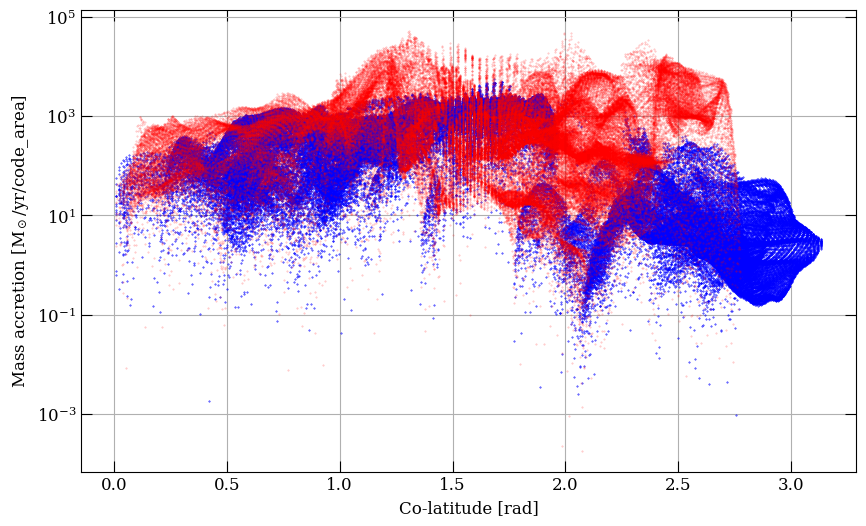

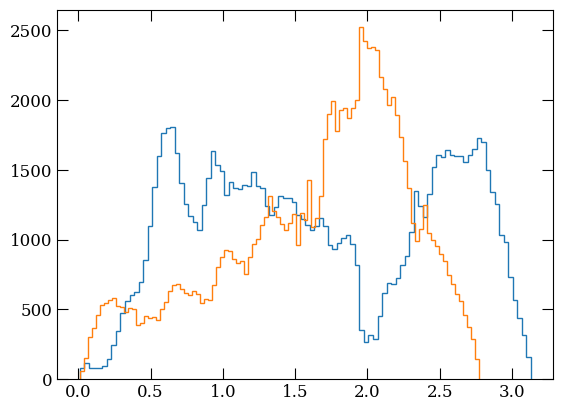

In [22]:
shell_r=50; shell_Δpct=0.05

shell_r /= data.au_length
Δ_r = np.maximum(shell_Δpct * shell_r, 2.5 * 0.5 ** data.lmax) 

colatitude = [] # θ going from 0 to π from north to south
longtitude = [] # φ going from 0 to 2π around the equator 
patch_values = []
patch_mass = []
cell_level = []

pp = [p for p in data.sn.patches if (p.dist_xyz < shell_r * 2).any() and p.level > 5]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

for p in tqdm.tqdm(sorted_patches, disable=(not data.loading_bar)):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position) ** 2).sum() < (p.size ** 2).sum() / 12]
    if len(leafs) == 8: continue
    to_extract = (p.dist_xyz < shell_r + Δ_r) & (p.dist_xyz > shell_r - Δ_r)
    for lp in leafs:
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all(((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None])), axis=0)
        to_extract *= covered_bool

    new_xyz = p.rel_xyz[:, to_extract].T
    new_R = np.linalg.norm(new_xyz, axis=1)
    new_value = (p.var('d') * np.sum((p.vrel *  p.rel_xyz / np.linalg.norm(p.rel_xyz, axis=0)), axis=0))[to_extract].T
    mass = p.m[to_extract].T
    longtitude.extend((np.arctan2(new_xyz[:, 1], new_xyz[:, 0]) + np.pi).tolist())
    colatitude.extend(np.arccos(new_xyz[:, 0] / new_R).tolist()) 

    patch_values.extend(new_value.tolist())
    patch_mass.extend(mass.tolist())
    cell_level.extend(p.level * np.ones(len(mass)))

longtitude = np.asarray(longtitude)
colatitude = np.asarray(colatitude)
patch_values = np.asarray(patch_values)
patch_mass = np.asarray(patch_mass)
cell_level = np.asarray(cell_level)


fig, axs = plt.subplots( figsize = (10,6))

axs.set(ylabel = 'Mass accretion [M$_\odot$/yr/code_area]', xlabel = 'Co-latitude [rad]')
axs.grid()
values = patch_values * - data.msun_mass/data.yr_time

bool = values < 0
axs.semilogy(colatitude[bool], abs(values)[bool], '.', markersize = 0.75, color = 'blue', label = 'Outflow')

bool = values > 0
axs.semilogy(colatitude[bool], abs(values)[bool], '.', markersize = 0.75, color = 'red', label = 'Inflow', alpha = 0.3)

plt.figure()
bool = values < 0
plt.hist(colatitude[bool], bins = 100, histtype='step');
bool = values > 0
plt.hist(colatitude[bool], bins = 100, histtype='step');


In [24]:
patch_values

array([-3605797.85116622, -3271340.75870676, -3182762.03065057, ...,
        1083769.43293285, -3004727.22033591, -9229686.37943979])

In [13]:
m_data = np.zeros(npix)
cell_area = hp.nside2pixarea(nside) * shell_r**2
used_cells = 0

for i in tqdm.tqdm(range(npix)):
    bool = (pixel_indices == i)
    if np.sum(bool) < 1:continue

    m_data[i] = np.average(patch_values[bool], weights=patch_mass[bool]) 
    used_cells += len(patch_values[bool])
    
print('Used cells ', used_cells)

m_data *= -data.msun_mass / data.sn.cgs.yr  

NameError: name 'npix' is not defined

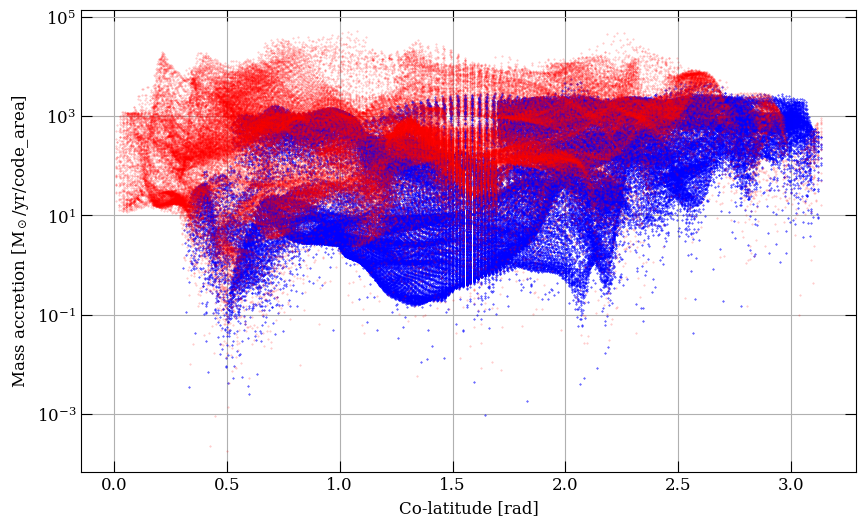

In [85]:
fig, axs = plt.subplots( figsize = (10,6))

axs.set(ylabel = 'Mass accretion [M$_\odot$/yr/code_area]', xlabel = 'Co-latitude [rad]')
axs.grid()
values = patch_values * - data.msun_mass/data.yr_time

bool = values < 0
axs.semilogy(colatitude[bool], abs(values)[bool], '.', markersize = 0.75, color = 'blue', label = 'Outflow')

bool = values > 0
axs.semilogy(colatitude[bool], abs(values)[bool], '.', markersize = 0.75, color = 'red', label = 'Inflow', alpha = 0.3)




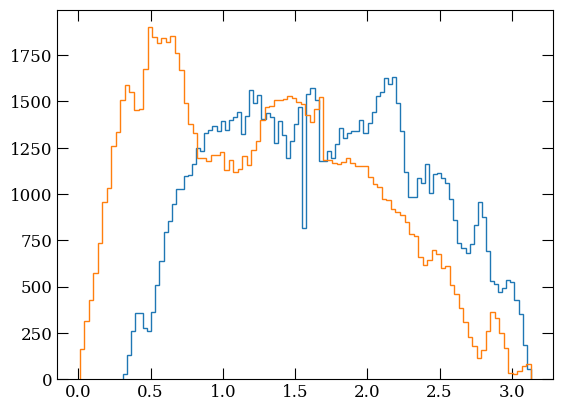

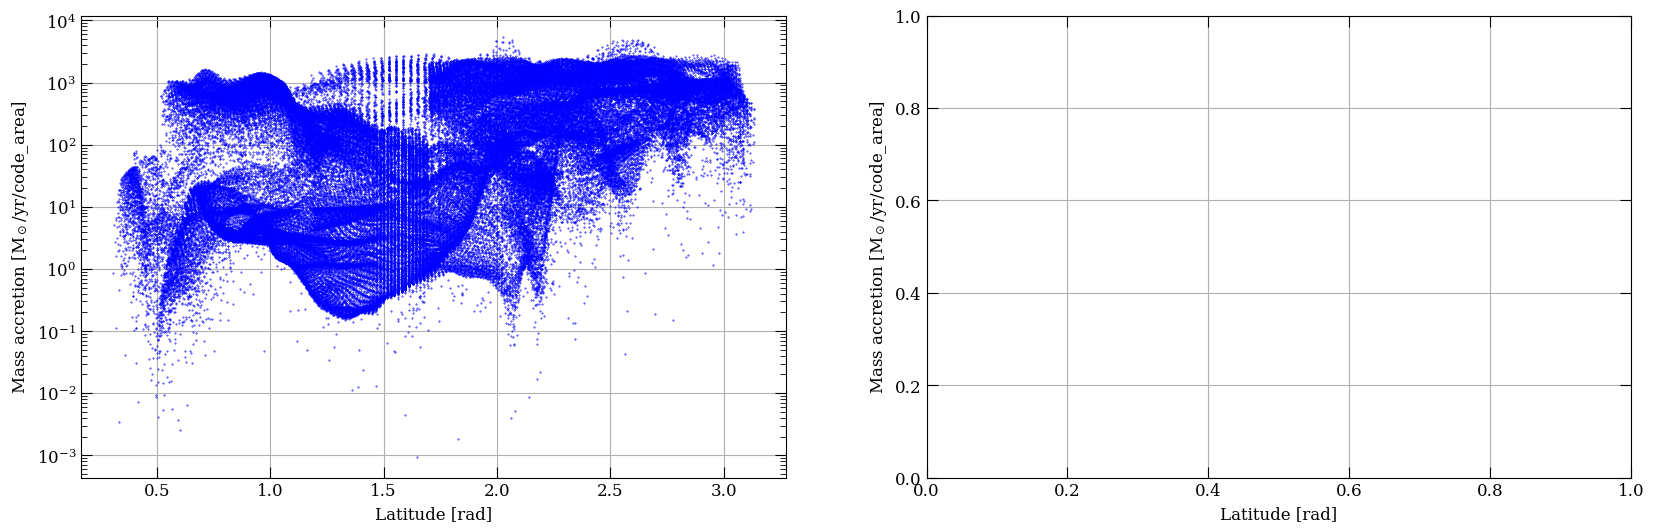

In [66]:
fig, axs = plt.subplots(1,2, figsize = (20,6))

for ax in axs.flatten():
    ax.set(ylabel = 'Mass accretion [M$_\odot$/yr/code_area]', xlabel = 'Latitude [rad]')
    ax.grid()

for ax, lat, values in zip(axs.flatten(), [colatitude], [patch_values * - data.msun_mass/data.yr_time]):
    bool = values > 0
    ax.semilogy(lat[~bool], abs(values)[~bool], '.', markersize = 0.75, color = 'blue', label = 'Outflow')



In [26]:
nside = 40; print('Number of cells on the sphere: ',hp.nside2npix(nside))
pixel_indices = hp.ang2pix(nside, colatitude, longtitude)
index, counts = np.unique(pixel_indices, return_counts=True); 
npix = hp.nside2npix(nside)
m = np.zeros(npix)
m[index] = counts
print('Cells without any representation: ', np.sum(m == 0))
print('Percentage of no-coverage: ', np.sum(m == 0) / npix * 100,'%' )

Number of cells on the sphere:  19200
Cells without any representation:  256
Percentage of no-coverage:  1.3333333333333335 %


/tmp/ipykernel_2513879/3401867338.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap.set_bad(color='red')


<Figure size 1200x800 with 0 Axes>

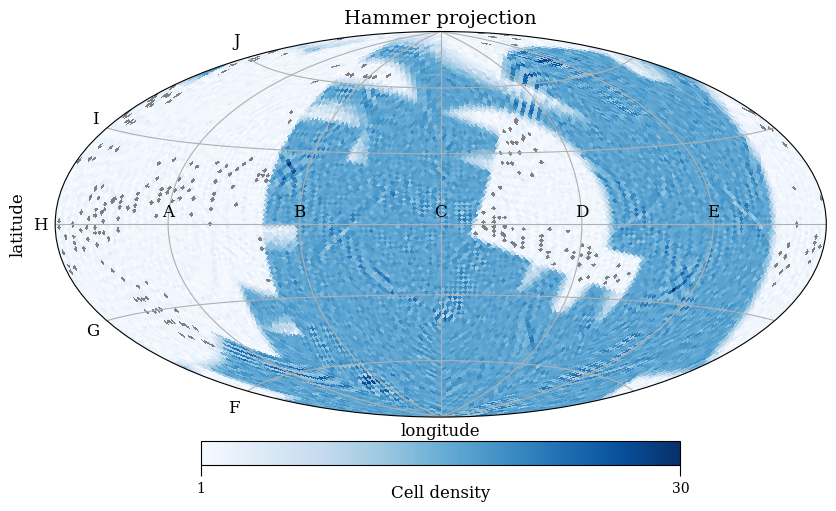

In [29]:
cmap = mpl.cm.Blues
cmap.set_bad(color='red')

m[m == 0] = np.nan

fig = plt.figure(figsize = (12,8)) 
ax = projview(
    m,
    coord=["G"],
    cmap = cmap,
    graticule=True,
    graticule_labels=True,
    xlabel="longitude",
    ylabel="latitude",
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    custom_xtick_labels=["A", "B", "C", "D", "E"],
    custom_ytick_labels=["F", "G", "H", "I", "J"],
    unit = 'Cell density'
    
);


In [17]:
pixel_indices = hp.ang2pix(nside, colatitude, longtitude)
index, counts = np.unique(pixel_indices, return_counts=True); 

In [18]:
m_data = np.zeros(npix)
cell_area = hp.nside2pixarea(nside) * shell_r**2
used_cells = 0

for i in tqdm.tqdm(range(npix)):
    bool = (pixel_indices == i)
    if np.sum(bool) < 1:continue
    bool_2 = (cell_level[bool] == cell_level[bool].max()) 
    #m_data[i] = np.average(patch_values[bool], weights=patch_mass[bool]) * cell_area
    used_cells += len(patch_values[bool][bool_2])
    m_data[i] = np.average(patch_values[bool][bool_2], weights=patch_mass[bool][bool_2]) * cell_area
print('Used cells ', used_cells)

m_data *= -data.msun_mass / data.sn.cgs.yr  

100%|██████████| 19200/19200 [00:06<00:00, 3065.61it/s]

Used cells  205642


In [30]:
m_data = np.zeros(npix)
cell_area = hp.nside2pixarea(nside) * shell_r**2
used_cells = 0

for i in tqdm.tqdm(range(npix)):
    bool = (pixel_indices == i)
    if np.sum(bool) < 1:continue

    m_data[i] = np.average(patch_values[bool], weights=patch_mass[bool]) * cell_area
    used_cells += len(patch_values[bool])
    
print('Used cells ', used_cells)

m_data *= -data.msun_mass / data.sn.cgs.yr  

100%|██████████| 19200/19200 [00:05<00:00, 3661.50it/s]

Used cells  207731


<Figure size 1200x800 with 0 Axes>

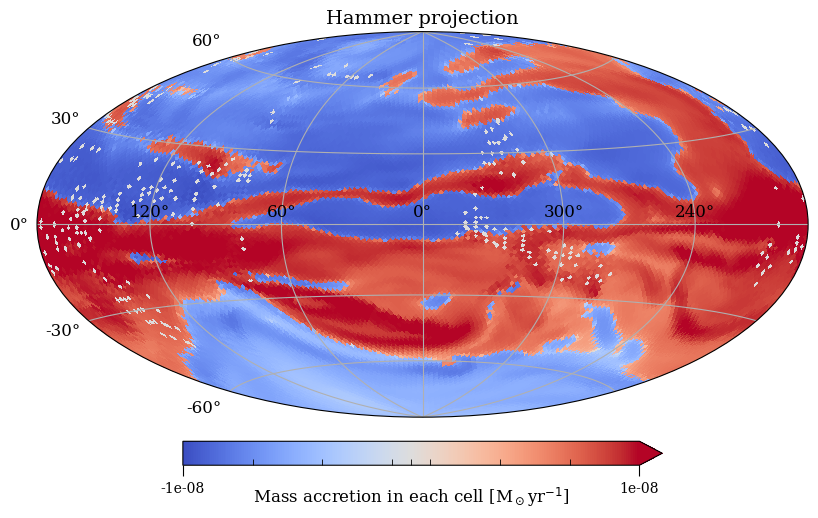

In [31]:
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    m_data,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    coord=["G"],
    cmap = 'coolwarm',
    graticule=True,
    graticule_labels=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$yr$^{-1}$]'
);


In [21]:
'''m_data[m_data == 0] = np.nan
mask = np.isnan(m_data)
inter_f = interp1d(np.arange(npix)[~mask], m_data[~mask], kind = 'linear', fill_value= 'extrapolate')
m_f = inter_f(np.arange(npix))'''

"m_data[m_data == 0] = np.nan\nmask = np.isnan(m_data)\ninter_f = interp1d(np.arange(npix)[~mask], m_data[~mask], kind = 'linear', fill_value= 'extrapolate')\nm_f = inter_f(np.arange(npix))"

In [22]:
'''fig = plt.figure(figsize = (12,8)) 
ax = projview(
    m_f,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    cmap = 'coolwarm',
    coord = ['E'],
    graticule=True,
    graticule_labels=True,
    rot = (0, 180),
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$ yr$^{-1}$]',
);
'''


'fig = plt.figure(figsize = (12,8)) \nax = projview(\n    m_f,\n    norm = \'symlog\',\n    max = 1e-8,\n    min = -1e-8,\n    norm_dict = {\'linthresh\': 1e-14, \'linscale\': 0.5},\n    cmap = \'coolwarm\',\n    coord = [\'E\'],\n    graticule=True,\n    graticule_labels=True,\n    rot = (0, 180),\n    cb_orientation="horizontal",\n    latitude_grid_spacing=30,\n    projection_type="hammer",\n    title="Hammer projection",\n    unit = r\'Mass accretion in each cell [M$_\\odot$ yr$^{-1}$]\',\n);\n'

In [23]:
masked = ma.masked_where(m_data == 0, m_data)


In [24]:
(m_data == 0).sum()

256

In [668]:
zero_values = (m_data == 0)

theta, phi = hp.pix2ang(nside, np.arange(npix)[zero_values])
interpolated_values = hp.get_interp_val(m_data[~masked.mask], theta, phi)
m_data[zero_values] = interpolated_values; interpolated_values

ValueError: Wrong pixel number (it is not 12*nside**2)

In [663]:
zero_values.sum()

0

In [624]:
neighbours = hp.get_all_neighbours(nside, theta[1], phi[1])

In [625]:
hp.get_interp_weights(nside, theta[1], phi[1])

(array([100, 101, 130, 131]),
 array([1.00000000e+00, 0.00000000e+00, 9.58705015e-15, 5.32613897e-15]))

In [638]:
z = np.array([m_data[i] for i in neighbours])

In [647]:
new_z = np.insert(z, 4, np.nan).reshape(3,3)

In [648]:
x = np.arange(-1,2,1); y = np.arange(-1,2,1)
xx, yy = np.meshgrid(x,y)
inter = interp2d(xx, yy, new_z)


/tmp/ipykernel_1515216/3907996599.py:3: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  inter = interp2d(xx, yy, new_z)
/software/astro/anaconda/anaconda3-2021.05/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=6,5 m=9 fp=nan s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [650]:
inter(0,0)

/tmp/ipykernel_1515216/3247478205.py:1: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  inter(0,0)


array([nan])

In [553]:
interpolated_values = hp.get_interp_weights(nside, theta, phi)

In [556]:
np.shape(interpolated_values)

(2, 4, 256)

In [536]:
interpolated_values

array([0., 0., 0., ..., 0., 0., 0.])

In [532]:
interpolated_values

array([0., 0., 0., ..., 0., 0., 0.])

In [526]:
interpolated_values

array([0., 0., 0., ..., 0., 0., 0.])

<Figure size 1200x800 with 0 Axes>

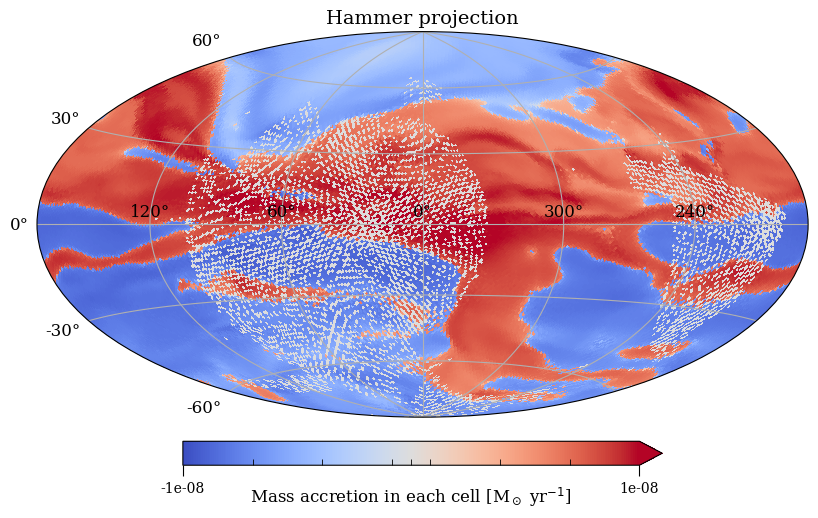

In [609]:
fig = plt.figure(figsize = (12,8)) 
ax = projview(
    m_f2,
    norm = 'symlog',
    max = 1e-8,
    min = -1e-8,
    norm_dict = {'linthresh': 1e-14, 'linscale': 0.5},
    cmap = 'coolwarm',
    coord = ['C'],
    graticule=True,
    graticule_labels=True,
    rot = (0, 180),
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="hammer",
    title="Hammer projection",
    unit = r'Mass accretion in each cell [M$_\odot$ yr$^{-1}$]',
);

